In [1]:
import ot
import numpy as np
from scipy.stats import kstest

In [2]:
data = np.loadtxt("../data/Langevin_1D.txt")
truth_data = np.loadtxt("../data/ChangePts.txt")

<Figure size 640x480 with 0 Axes>

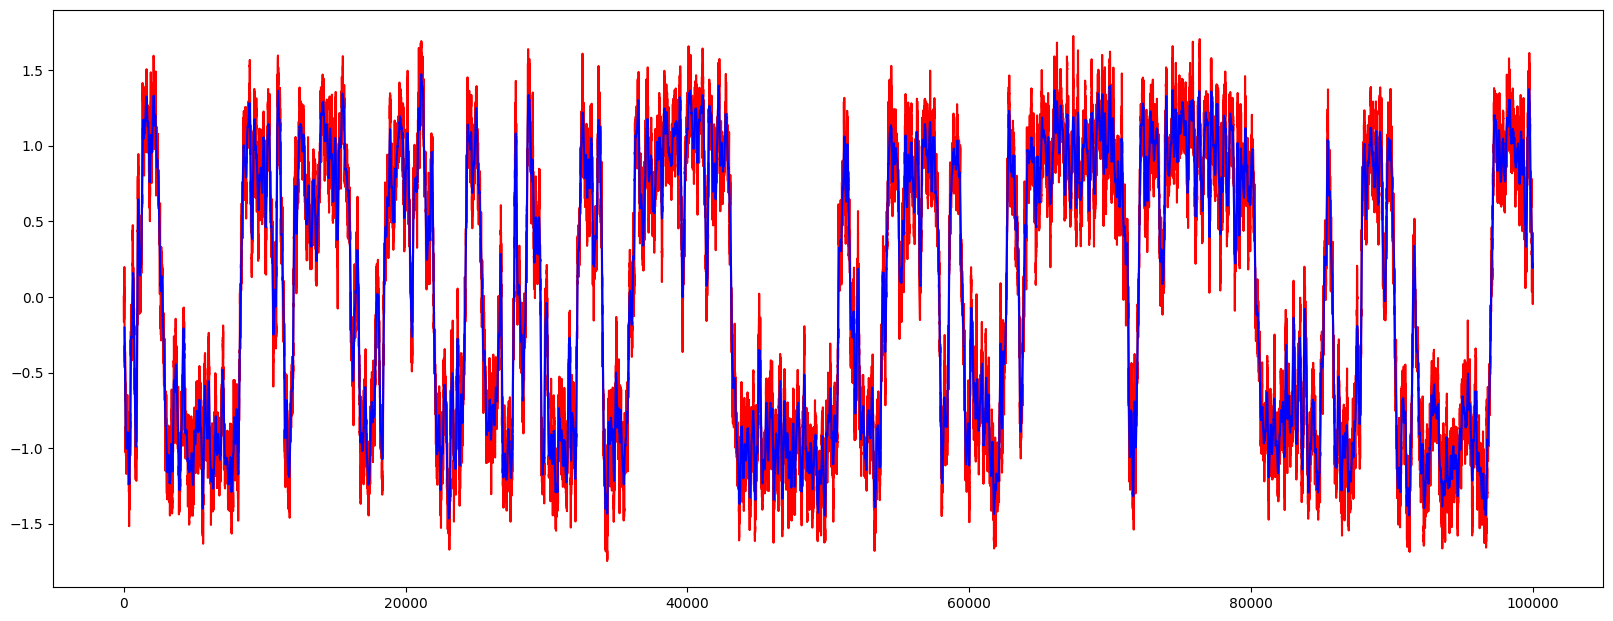

In [9]:
# f(t) = avg(k-nearest(window(t)))
# so, subset the data around t according to window size
# find the k nearest neighbors for the data point at t
# average those neighbors and call that average your smooth point at t
import matplotlib.pyplot as plt

def knearest(val, series, k=2):
    distances = enumerate([abs(val - x) for x in series])
    sorted_dists = sorted(distances, key=lambda x:x[1])
    indices = [dist[0] for dist in sorted_dists][0:k]
    values = [series[index] for index in indices]
    return np.average(values)

half_window = 50

smooth_data = [np.average(data[(t - half_window):(t + half_window)]) for t in range(len(data))]
plt.clf()
fig, ax = plt.subplots()
fig.set_size_inches(20,7.5)
ax.plot(np.arange(len(data)), data, c='r')
ax.plot(np.arange(len(smooth_data)), smooth_data, c='b')


In [5]:

window_size = 250
ks_stats = [kstest(smooth_data[(t - window_size):t], smooth_data[t:(t + window_size)]).statistic for t in range(window_size, len(smooth_data) - window_size)]
dw_data = [ot.emd2_1d(smooth_data[(t - window_size):t], smooth_data[t:(t + window_size)]) for t in range(window_size, len(smooth_data) - window_size)]
change_points = [t in truth_data for t in range(len(data))]

ks_tp, ks_fp, ks_fn, dw_tp, dw_fp, dw_fn = 0,0,0,0,0,0
ks_cutoff = 0.9
dw_cutoff = 0.85
tolerance = 100
ks_cps = [x > ks_cutoff for x in ks_stats]
dw_cps = [x > dw_cutoff for x in dw_data]

In [6]:
for t in range(len(smooth_data) - 2 * window_size):
    # if we detected a change point and there IS a true change point in the tolerance window, tp++
    if ks_cps[t] and True in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        ks_tp +=1
    if dw_cps[t] and True in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        dw_tp +=1
    # if we detected a change point and there IS NOT a true change point in the tolerance window, fp++
    if ks_cps[t] and True not in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        ks_fp +=1
    if dw_cps[t] and True not in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        dw_fp +=1
    # if we did not detect and change point and there IS a true change point int he tolerance window, fn++
    if not ks_cps[t] and True in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        ks_fn +=1
    if not dw_cps[t] and True in change_points[(t + window_size - tolerance):(t + window_size + tolerance)]:
        dw_fn +=1
ks_tp, ks_fp, ks_fn, dw_tp, dw_fp, dw_fn

(8452, 13671, 4496, 5235, 1460, 7713)

In [7]:
ks_recall = ks_tp / (ks_tp + ks_fn)
dw_recall = dw_tp / (dw_tp + dw_fn)
ks_precision = ks_tp / (ks_tp + ks_fp)
dw_precision = dw_tp / (dw_tp + dw_fp)
ks_f1 = 2 / ((1 / ks_recall) + (1 / ks_precision))
dw_f1 = 2 / ((1 / dw_recall) + (1 / dw_precision))
print(ks_recall, ks_precision, ks_f1)

0.652764905776954 0.38204583465171993 0.4819936699837472


0.456258755502303


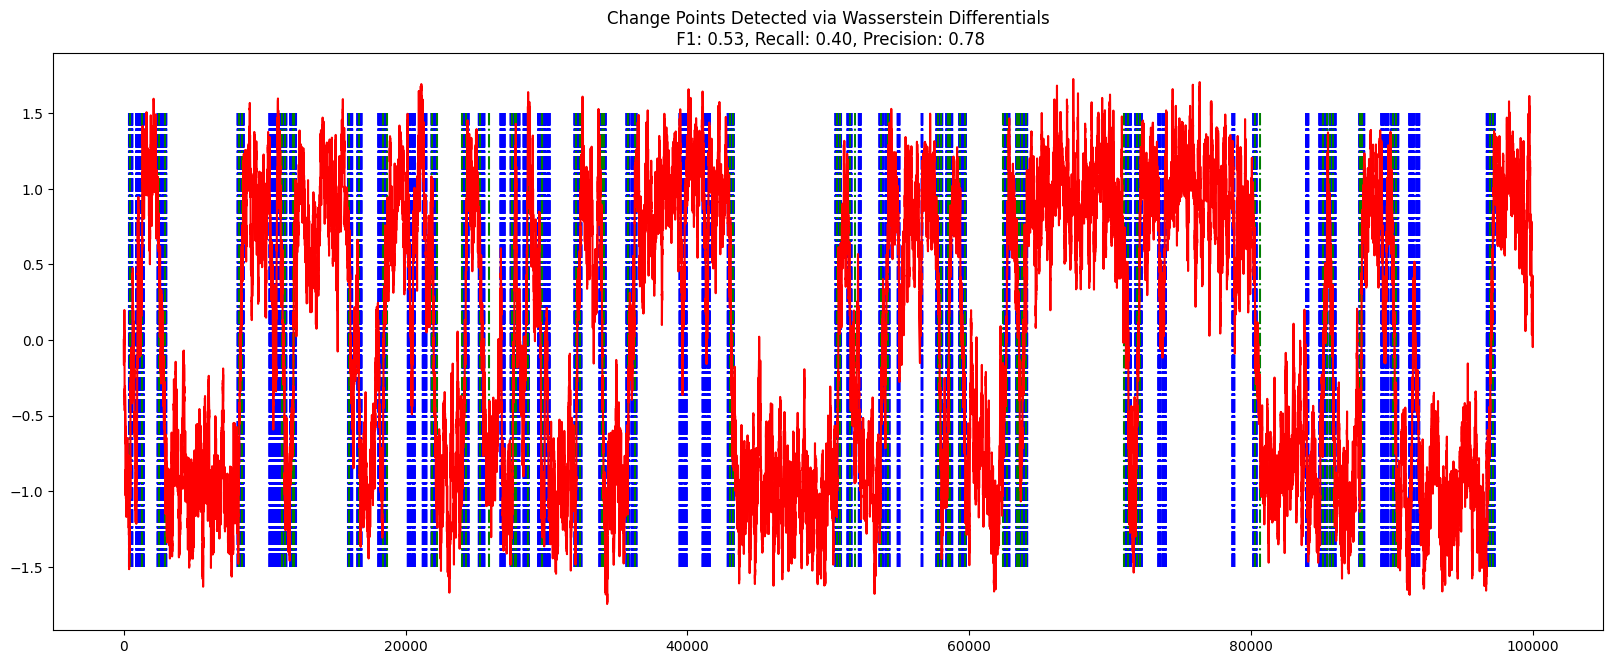

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20,7.5)
cutoff = np.quantile(dw_data[window_size:], 0.85)
print(cutoff)
#ax.plot(np.arange(window_size, len(data) - window_size), ks_stats, c='b')
for t in range(window_size, len(smooth_data) - window_size):
    if dw_data[t - window_size] > cutoff:
        ax.vlines(t, -1.5, 1.5, colors='blue',linestyle='dashdot')
for t in range(len(data)):
    if change_points[t]:
        ax.vlines(t, -1.5, 1.5, colors='green',linestyle='dashdot')
ax.plot(np.arange(len(data)), data, c='red')
plt.title(f"Change Points Detected via Wasserstein Differentials\n F1: {dw_f1:0.2f}, Recall: {dw_recall:0.2f}, Precision: {dw_precision:0.2f}")
plt.savefig("../img/denoised_wass_diff.png")

<Figure size 640x480 with 0 Axes>